# Large Scale learning with ModelSelector
Very often we have many different products, regions, countries, shops...for which we need to delivery forecast. This can be easily done with `ModelSelector`. `ModelSelector` though does not bind you to use multiple data partitions and can also serve as convenient layer for accessing relevant information quickly.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
from hcrystalball.model_selection import ModelSelector
from hcrystalball.utils import get_sales_data
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Get Dummy Data

In [3]:
df = get_sales_data(n_dates=365*2, 
                    n_assortments=1, 
                    n_states=1, 
                    n_stores=2)

In [4]:
df.head()

,Store,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2,State,HolidayCode
Date,,,,,,,,,,
2013-08-01,817,25013,True,True,True,a,a,False,BE,DE-BE
2013-08-01,513,22514,True,True,True,a,a,False,BE,DE-BE
2013-08-02,513,19330,True,True,True,a,a,False,BE,DE-BE
2013-08-02,817,22870,True,True,True,a,a,False,BE,DE-BE
2013-08-03,513,16633,True,False,False,a,a,False,BE,DE-BE


In [5]:
# let's start simple
df_minimal = df[['Store','Sales']]

### Get predefined sklearn models

`ModelSelector` has already predefined large scale of hcrystalball models by their classes. To get this predefined gridsearch use `create_gridsearch` method. It will allow you to create hundereds of different models in a second. Here for the sake of time, we will use the advantage of the method for cv splits, default scorer etc. and just extend empty grid with two models

In [6]:
ms_minimal = ModelSelector(horizon=10, frequency='D')

In [7]:
# see full default parameter grid in hands on exercise
ms_minimal.create_gridsearch(
    sklearn_models=False,
    n_splits=2,
    between_split_lag=None,
    sklearn_models_optimize_for_horizon=False,
    autosarimax_models=False,
    prophet_models=False,
    tbats_models=False,
    exp_smooth_models=False,
    average_ensembles=False,
    stacking_ensembles=False)

### Extend with custom models

In [8]:
ms_minimal.add_model_to_gridsearch(get_sklearn_wrapper(LinearRegression))
ms_minimal.add_model_to_gridsearch(get_sklearn_wrapper(RandomForestRegressor))

### Run model selection
Method `select_model` is doing majority of the magic for you - it creates forecast for each combination of columns specified in `partition_columns` and for each of the time series it will run grid_search mentioned above. Optionally once can select list of columns over which the model selection will run in parallel using prefect (`parallel_over_columns`). 

Required format for data is Datetime index, unsuprisingly numerical column for `target_col_name` all other columns except `partition_columns` will be used as exogenous variables - as additional features for modeling.

In [9]:
ms_minimal.select_model(df=df_minimal, partition_columns=['Store'], target_col_name='Sales')

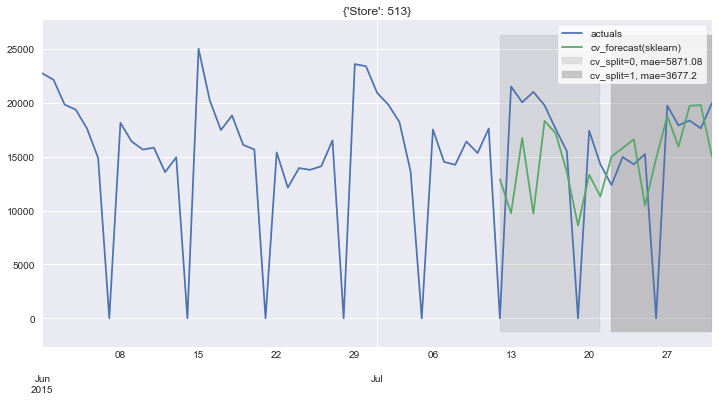

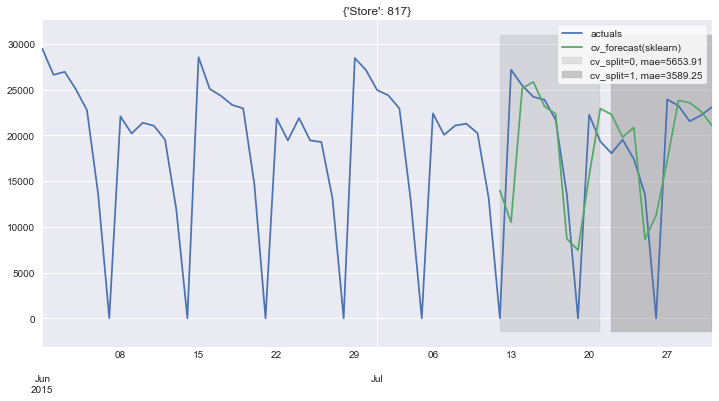

In [10]:
ms_minimal.plot_results(plot_from='2015-06')

## Persist and Load
`ModelSelector` stores multiple `ModelSelectorResults` in given folder as pickle files. As we only have 1 partition, only 1 file is written and loaded back.

In [11]:
ms_minimal

ModelSelector
-------------
  frequency: D
  horizon: 10
  country_code_column: None
  results: List of 2 ModelSelectorResults
  paritions: List of 2 partitions
     {'Store': 513}
     {'Store': 817}
-------------

In [12]:
ms_minimal.persist_results('results')

In [13]:
from hcrystalball.model_selection import load_model_selector

In [14]:
ms_loaded = load_model_selector('results')

In [15]:
ms_loaded

ModelSelector
-------------
  frequency: D
  horizon: 10
  country_code_column: None
  results: List of 2 ModelSelectorResults
  paritions: List of 2 partitions
     {'Store': 513}
     {'Store': 817}
-------------

In [16]:
# cleanup
import shutil
try:
    shutil.rmtree('results')
except:
    pass